In [ ]:
!mkdir gazeset_1
#!gdown https://drive.google.com/uc?id=1wqTA4gutC-L4h8TcMMQO_3jJYBL15-h3
!unzip -qq "/content/drive/MyDrive/data/UnityEye/UnityEye Archive.zip" -d gazeset_1

!mkdir gazeset
!unzip -qq "/content/drive/MyDrive/data/UnityEye/imgs50.zip" -d gazeset

In [ ]:
!ls /content/gazeset/imgs | wc -l

107969


In [ ]:
!find /content/gazeset/imgs -mindepth 1 -type f -name "*.json" -printf x | wc -c

53984


In [ ]:
!for FILENAME in $(ls /content/gazeset_1/imgs/); do mv /content/gazeset_1/imgs/$FILENAME /content/gazeset/imgs/1_$FILENAME; done

In [ ]:
!ls /content/gazeset/imgs | wc -l

129552


In [ ]:
!find /content/gazeset/imgs -mindepth 1 -type f -name "*.jpg" -printf x | wc -c

64775


In [ ]:
!rm -r eye

rm: cannot remove 'eye': No such file or directory


In [ ]:
!mkdir eye
!git clone https://github.com/Etzelkut/Eye-Tracking.git /content/eye

Cloning into '/content/eye'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 275 (delta 170), reused 186 (delta 86), pack-reused 0
Receiving objects: 100% (275/275), 1.94 MiB | 11.30 MiB/s, done.
Resolving deltas: 100% (170/170), done.


In [ ]:
!pip install local-attention
!pip install axial-positional-embedding
!pip install adabelief-pytorch
!pip install ranger-adabelief
!pip install pytorch-lightning
!pip install comet-ml
!pip install einops

In [ ]:
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import sys

In [ ]:
from eye.basem.basic_dependency import *
from eye.gaze_track.pl_model_train import Gaze_Track_pl
from eye.gaze_track.datasets import Dataset_Unity_pl

In [ ]:
class CheckpointEveryNSteps(pl.Callback):
    """
    Save a checkpoint every N steps, instead of Lightning's default that checkpoints
    based on validation loss.
    """

    def __init__(
        self,
        save_step_frequency,
        prefix="N-Step-Checkpoint",
        use_modelcheckpoint_filename=False,
        pathh = False,
    ):
        """
        Args:
            save_step_frequency: how often to save in steps
            prefix: add a prefix to the name, only used if
                use_modelcheckpoint_filename=False
            use_modelcheckpoint_filename: just use the ModelCheckpoint callback's
                default filename, don't use ours.
        """
        self.save_step_frequency = save_step_frequency
        self.prefix = prefix
        self.use_modelcheckpoint_filename = use_modelcheckpoint_filename
        self.pathh = pathh

    def on_batch_end(self, trainer: pl.Trainer, _):
        """ Check if we should save a checkpoint after every train batch """
        epoch = trainer.current_epoch
        global_step = trainer.global_step
        if global_step % self.save_step_frequency == 0:
            if self.use_modelcheckpoint_filename:
                filename = trainer.checkpoint_callback.filename
            else:
                filename = f"{self.prefix}_{epoch}_{global_step}.ckpt"
            ckpt_path = os.path.join(self.pathh, filename)
            print("we are here!!!")
            trainer.save_checkpoint(ckpt_path)

In [ ]:
base_args = {
    "d": 0,
    "new_d": 256,
    "im_size": (96, 160),
    "patch_size": 16,
    "grayscale": True,
    "max_epochs": 30, 

    "halfing": False,

    "alternative_landmarks": True,
    "add_heatmap_loss": False,
}



########################


main_example_attention_block = {
    "type_module" : "gcn", #att, gcn, gcn_no_wn, linear, rpr, local_sa, glu_alt, light, dynamic
    "d": base_args["new_d"],
    "dropout": 0.05, # in some dropout do not exist
    "num_heads": 2, #if type_module == local_sa, then n_local_attn_heads + global = num_heads
    #params for local_sa
    "n_local_attn_heads": 0,
    "local_attn_window_size": 50,
    #params for glu
    "k_kernel_glu": 4,
    "downbot_glu": 2,
    #for rpr type
    "max_relative_positions_rpr": 8,
    #for dynamic and light
    #"kernel_size_dynamic": 30, 
    #for glu alt
    "alt_num_layers": 1,
    "alt_patch_size": 3,
    "alt_padding": 1,
}

add_example_attention_block = {
    "type_module" : "linear", #att, gcn, gcn_no_wn, linear, rpr, local_sa, glu_alt, #light, dynamic
    "d": base_args["new_d"],
    "dropout": 0.05, # in some dropout do not exist
    "num_heads": 2, #if type_module == local_sa, then n_local_attn_heads + global = num_heads
    #params for local_sa
    "n_local_attn_heads": 0,
    "local_attn_window_size": 50,
    #params for glu
    "k_kernel_glu": 4,
    "downbot_glu": 2,
    #for rpr type
    "max_relative_positions_rpr": 8,
    #for dynamic and light
    #"kernel_size_dynamic": 30, 
    #for glu alt
    "alt_num_layers": 1,
    "alt_patch_size": 3,
    "alt_padding": 1,
}


example_branch = {
    "type_module": "1d", #2d
    "d_model": base_args["new_d"],
    "out_d": 256,
}


example_evolved_encoder_hparams = {
    "d": base_args["new_d"],
    "number_of_main": 1,
    "main_attention_block": main_example_attention_block,
    "branched_conv": example_branch,
    
    "number_of_add": 1,
    "add_attention_block": add_example_attention_block,

    "norm_after_block":False,
}

#########################



example_attention_block = {
    "type_module" : "att", #att, gcn, gcn_no_wn, linear, rpr, local_sa, glu_alt, #light, dynamic
    "d": base_args["new_d"],
    "dropout": 0.05, # in some dropout do not exist
    "num_heads": 4, #if type_module == local_sa, then n_local_attn_heads + global = num_heads
    #params for local_sa
    "n_local_attn_heads": 2,
    "local_attn_window_size": 32,
    #params for glu
    "k_kernel_glu": 4,
    "downbot_glu": 2,
    #for rpr type
    "max_relative_positions_rpr": 8,
    #for dynamic and light
    #"kernel_size_dynamic": 30, 
    #for glu alt
    "alt_num_layers": 1,
    "alt_patch_size": 3,
    "alt_padding": 1,
}


example_encoder_hparams = {
    "attention_block": example_attention_block,
    "d": base_args["new_d"],
    "ff_type": "fc", #fc, conv
    "ff_activation_type": "mish", #swish or gelu
    "ff_glu": False,
    "ff_dropout": 0.05,
    # encoder block params
    "layers_number":2,
    "norm_after_block":False,
    "alternative_weight_init": False,
}


example_emb = {
    "add_emb": False, # if false will run normal embeding from the ViT
    "emb_module": {
        "type_module": "axial", # const
        "d": base_args["new_d"], # dimensions
        "dropout": 0.1,
    }
}


example_resize = {
    "add_resize": True, 
    "resize_module": {
        "type_module": "fc", #fc, 1dconv
        "size": base_args["d"], # dimensions
        "new_size": base_args["new_d"],
    },
}


example_feature_extract_hparams = {
    "grayscale": base_args["grayscale"],
    "im_size": base_args["im_size"],
    "patch_size": base_args["patch_size"],
    "d_model_emb": base_args["new_d"],

    "resize_": example_resize,
    "pos_emb": example_emb,
    "dropout": 0.05,
    "number_of_learn_params": 1,
    "encoder_type": "transformer", # transformer, evolved
    "encoder_params": example_encoder_hparams, #example_evolved_encoder_hparams,

    "alternative_landmarks": base_args["alternative_landmarks"],

    "add_additional_train_landmarks": True,

    "halfing": base_args["halfing"],
    "add_pool_end": False,
}



train_hparams_example = {
    "optimizer": "adamW", # "belief", "ranger_belief", "adam", adamW
    "lr": 3e-4, #
    "epochs": base_args['max_epochs'], #
    #
    "add_sch": False,
    #
    #belief
    "eplison_belief": 1e-16,
    "beta": [0.9, 0.999], # not used
    "weight_decouple": True, 
    "weight_decay": 1e-4,
    "rectify": True,

}

dataset_hparams = {
    "img_dir": None,
    "grayscale": base_args["grayscale"],
    "im_size": base_args["im_size"],
    "batch_size": 64,
    "num_workers":2,
    "dataloader_shuffle": True,

    "halfing": base_args["halfing"],

    "alternative_landmarks": base_args["alternative_landmarks"],
}

example_model_hparams = {
    "type": "trans_based", # not used
    "feature_extractor_hparams": example_feature_extract_hparams,

    "alternative_landmarks": base_args["alternative_landmarks"],
    "add_heatmap_loss": base_args["add_heatmap_loss"],
    "im_size": base_args["im_size"],

    "dataset_h": dataset_hparams,

    "mlp_drop": 0.05,
    "gaze_size": 2,
    "training": train_hparams_example,
}

In [ ]:
seed_v = 42
seed_everything(seed_v)

root_dir = "/content/drive/MyDrive/eye_w/weights"
naming = "trans_2_3e4_att_256_1learnparam_noNorm_land_alt_data_"
from datetime import datetime

comet_logger = CometLogger(
  save_dir='/content/log/',
    api_key="23CU99n7TeyZdPeegNDlQ5aHf",
    project_name="gaze2",
    workspace="etzelkut",
  # rest_api_key=os.environ["COMET_REST_KEY"], # Optional
  experiment_name = naming, # Optional
)


#
dataset_pl = Dataset_Unity_pl(dataset_hparams)
dataset_pl.prepare_data()
dataset_pl.setup()
steps_per_epoch = int(len(dataset_pl.train_dataloader()))

every_epoch = CheckpointEveryNSteps(save_step_frequency = steps_per_epoch*2, 
                                    use_modelcheckpoint_filename = False, 
                                    pathh=root_dir, prefix=naming+"N-Step-Checkpoint")


proj_a = Gaze_Track_pl(example_model_hparams, steps_per_epoch = steps_per_epoch)


trainer = Trainer(callbacks=[every_epoch],
                  logger=comet_logger,
                  gpus=1,
                  profiler='simple',
                  #auto_lr_find=True, #set hparams
                  #gradient_clip_val=0.5,
                  check_val_every_n_epoch=1,
                  #early_stop_callback=True,
                  max_epochs = example_model_hparams["training"]["epochs"],
                  progress_bar_refresh_rate = 0,
                  deterministic=True,)

#~
trainer.fit(proj_a, dataset_pl)
trainer.test(proj_a, dataset_pl)

#if re_dict["training"]["swa"]:
#  proj_a.change_for_swa(dataset_pl.train_dataloader())
#  trainer.test() # will it work?
#.

checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)
#copied with time for safety, not memory effec. but why bother I have infinite google drive
checkpoint_name = os.path.join(root_dir, naming + str(datetime.now()) + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

Global seed set to 42
CometLogger will be initialized in online mode


can add download here
halfing  is  False
alternative_landmarks  is  True
halfing and alt_land is:  False True
train
halfing and alt_land is:  False True
val
resize set to:  256  ->  256
adding alternative_landmarks in transformer
running classic ViT_pos_emb
used type is:  {'type_module': 'att', 'd': 256, 'dropout': 0.05, 'num_heads': 4, 'n_local_attn_heads': 2, 'local_attn_window_size': 32, 'k_kernel_glu': 4, 'downbot_glu': 2, 'max_relative_positions_rpr': 8, 'alt_num_layers': 1, 'alt_patch_size': 3, 'alt_padding': 1}
print positionwise Feed Forward with glu:  False


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning:

Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


print positionwise Feed Forward with glu:  True
alternative_landmarks is:  True
doint alt landmarks
halfing is:  False
alternative_landmarks  is  True
add_heatmap_loss  is  False


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/etzelkut/gaze2/172dc4e34b1344dfa33337108bd966b6


  | Name           | Type                  | Params
---------------------------------------------------------
0 | network        | Gaze_Predictor        | 3.0 M 
1 | augment        | DataAugmentationImage | 0     
2 | heatmapLoss    | HeatmapLoss           | 0     
3 | landmarks_loss | MSELoss               | 0     
4 | gaze_loss      | MSELoss               | 0     
---------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.985    T

we are here!!!


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:222: UserWarning:

You called `self.log('epoch_now', ...)` in your `training_epoch_end` but the value needs to be floating point. Converting it to torch.float32.



we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!


In [ ]:
#https://arxiv.org/pdf/2007.13120v1.pdf
checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

In [ ]:
################################################################

In [ ]:
seed_v = 42
seed_everything(seed_v)

root_dir = "/content/drive/MyDrive/eye_w/weights"
naming = "trans_2_3e4_att_256_1learnparam_noNorm_land_"
from datetime import datetime

comet_logger = CometLogger(
  save_dir='/content/log/',
    api_key="23CU99n7TeyZdPeegNDlQ5aHf",
    project_name="gaze2",
    workspace="etzelkut",
  # rest_api_key=os.environ["COMET_REST_KEY"], # Optional
  experiment_name = naming, # Optional
)


#

load_name = "/content/drive/MyDrive/eye_w/weights/trans_2_3e4_att_256_1learnparam_noNorm_land_N-Step-Checkpoint_16_10800.ckpt"

proj_a = Gaze_Track_pl.load_from_checkpoint(load_name)

dataset_hparams = proj_a.hparams["dataset_h"]

dataset_pl = Dataset_Unity_pl(dataset_hparams)
dataset_pl.prepare_data()
dataset_pl.setup()
steps_per_epoch = int(len(dataset_pl.train_dataloader()))

every_epoch = CheckpointEveryNSteps(save_step_frequency = steps_per_epoch, 
                                    use_modelcheckpoint_filename = False, 
                                    pathh=root_dir, prefix=naming+"N-Step-Checkpoint")



trainer = Trainer(callbacks=[every_epoch],
                  logger=comet_logger,
                  gpus=1,
                  profiler='simple',
                  #auto_lr_find=True, #set hparams
                  #gradient_clip_val=0.5,
                  check_val_every_n_epoch=1,
                  #early_stop_callback=True,
                  max_epochs = proj_a.hparams["training"]["epochs"],
                  progress_bar_refresh_rate = 0,
                  deterministic=True,
                  resume_from_checkpoint=load_name)

#~
trainer.fit(proj_a, dataset_pl)
trainer.test(proj_a, dataset_pl)

#if re_dict["training"]["swa"]:
#  proj_a.change_for_swa(dataset_pl.train_dataloader())
#  trainer.test() # will it work?
#.

checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)
#copied with time for safety, not memory effec. but why bother I have infinite google drive
checkpoint_name = os.path.join(root_dir, naming + str(datetime.now()) + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

In [ ]:
checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

In [ ]:
############################################

In [ ]:
#
from eye.gaze_track.datasets import UnityEyesDataset
from eye.gaze_track.augmentations import DataAugmentationImage, Preprocess
from eye.gaze_track.utils import draw_gaze

import matplotlib.pyplot as plt
import cv2

In [ ]:
load_name = "/content/drive/MyDrive/eye_w/weights/trans_3_3e4_att_256_1learnparam_noNorm_land_alt_data_N-Step-Checkpoint_10_8100.ckpt"

proj_a = Gaze_Track_pl.load_from_checkpoint(load_name)

resize set to:  256  ->  256
adding alternative_landmarks in transformer
running classic ViT_pos_emb
used type is:  {'type_module': 'att', 'd': 256, 'dropout': 0.05, 'num_heads': 4, 'n_local_attn_heads': 2, 'local_attn_window_size': 32, 'k_kernel_glu': 4, 'downbot_glu': 2, 'max_relative_positions_rpr': 8, 'alt_num_layers': 1, 'alt_patch_size': 3, 'alt_padding': 1}
print positionwise Feed Forward with glu:  False
print positionwise Feed Forward with glu:  True
alternative_landmarks is:  True
doint alt landmarks
halfing is:  False
alternative_landmarks  is  True
add_heatmap_loss  is  False


In [ ]:
#
dataset_val = UnityEyesDataset(img_dir = None, val = True, transform = Preprocess(), grayscale = True, output_size = (96, 160), alt_land=True)
val_set = DataLoader(dataset_val, batch_size = 20)
#dd = DataAugmentationImage(1)

halfing and alt_land is:  False True
val


In [ ]:
#
for xx in val_set:
  break

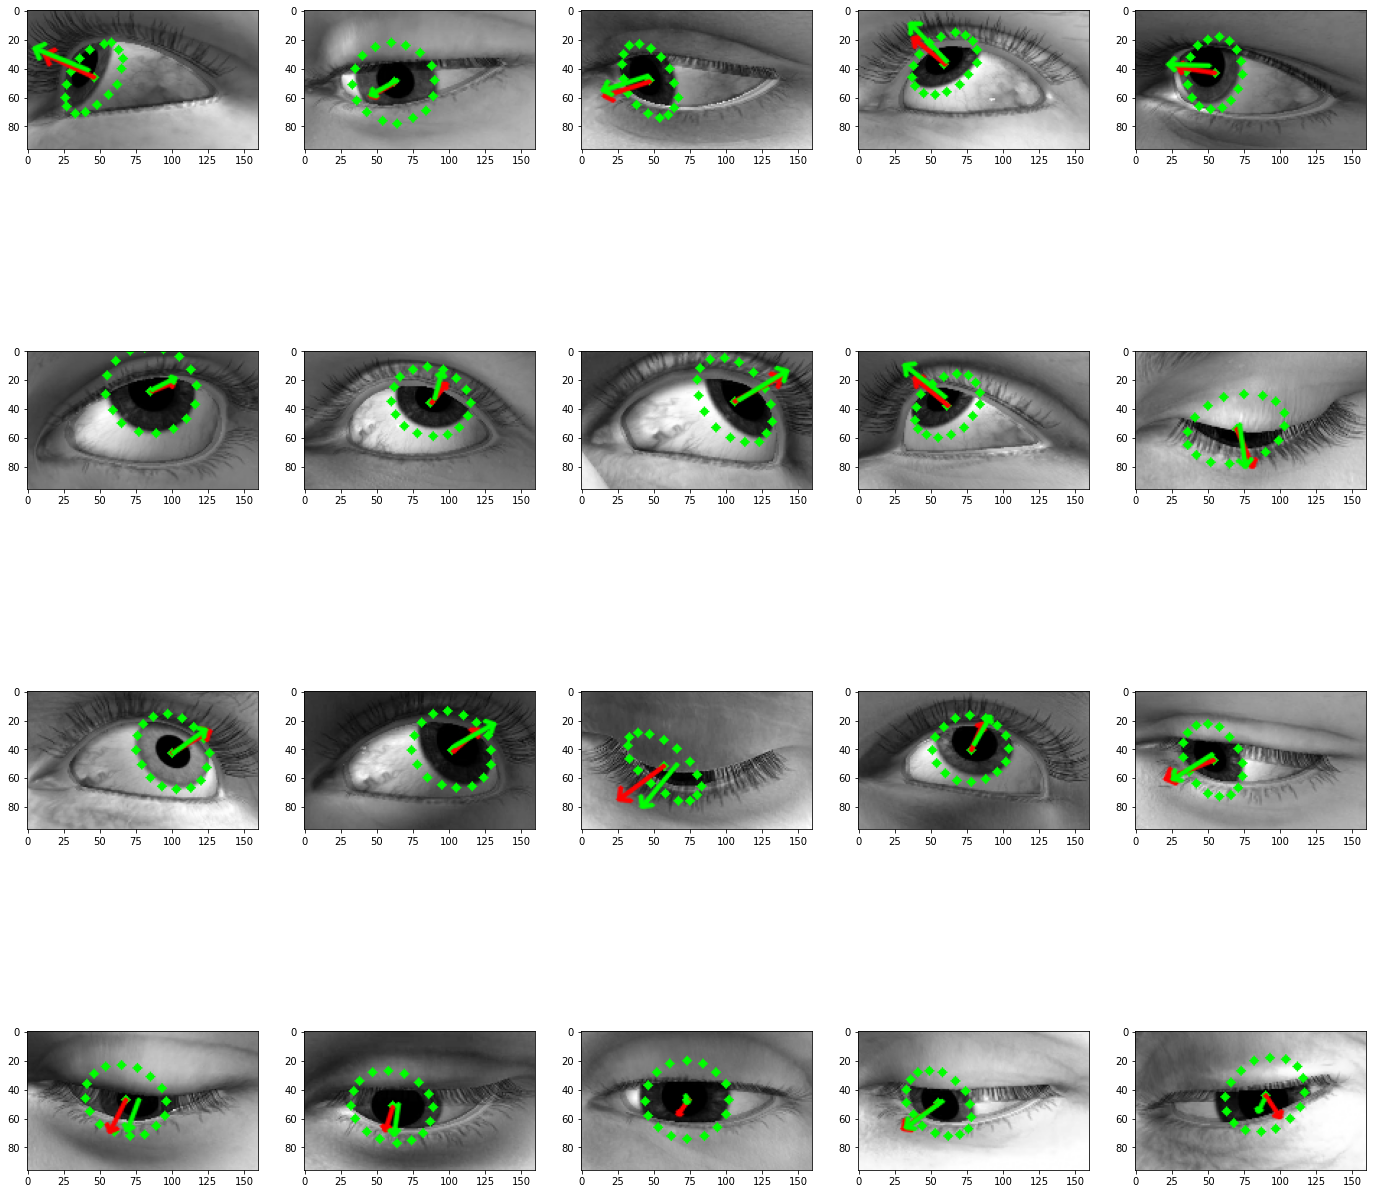

In [ ]:
w = 25
h = 25
fig = plt.figure(figsize=(24, 24))
columns = 5
rows = 4
for i in range(0, columns*rows):

    gaze, heatmaps, landmarks_out = proj_a(xx['img'][i][None])#.to('cuda'))
    xx['img'][i] = xx['img'][i][0]#.to('cpu')[0]

    gaze = gaze[0].detach().numpy()
    image = xx['img'][i].detach().numpy()
    landmarks = landmarks_out.detach().numpy()

    landmarks = proj_a.tranform_into_actual_coor(landmarks)
    landmarks = landmarks[0]

    eye_img = np.copy(image)
    eye_img = eye_img.transpose(1, 2, 0)
    eye_img = cv2.merge((eye_img,eye_img,eye_img))

    eye_img = cv2.normalize(eye_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    eye_img = eye_img.astype(np.uint8)

    landmarks[:, [1, 0]] = landmarks[:, [0, 1]]

    for (x, y) in landmarks[0:]:
        eye_img = cv2.circle(eye_img, (int(x), int(y)), 1, color=(0, 255, 0), thickness=3)
      
    eye_img = draw_gaze(eye_img, landmarks[-1], gaze, color=(255, 0, 0))

    gaze = xx['gaze'][i].detach().numpy()
    landmarks = np.copy(xx['landmarks'][i].detach().numpy())
    
    landmarks = proj_a.tranform_into_actual_coor(landmarks[None])
    landmarks = landmarks[0]

    landmarks[:, [1, 0]] = landmarks[:, [0, 1]]
    eye_img = draw_gaze(eye_img, landmarks[-1], gaze, color=(0, 255, 0))

    fig.add_subplot(rows, columns, i+1)
    plt.imshow(eye_img)

plt.show()

In [ ]:
#
w = 25
h = 25
fig = plt.figure(figsize=(20, 20))
columns = 5
rows = 2
for i in range(0, columns*rows):

    print("before norm")
    print(i, xx['img'][i].size(), torch.min(xx['img'][i]), torch.max(xx['img'][i]))
    
    xx['img'][i] = dd(xx['img'][i][None].to('cuda'), 1)
    xx['img'][i] = xx['img'][i].to('cpu')[0]

    print("after norm")
    print(i, xx['img'][i].size(), torch.min(xx['img'][i]), torch.max(xx['img'][i]))

    gaze = xx['gaze'][i].detach().numpy()
    image = xx['img'][i].detach().numpy()
    landmarks = np.copy(xx['landmarks'][i].detach().numpy())

    eye_img = np.copy(image)
    eye_img = eye_img.transpose(1, 2, 0)
    eye_img = cv2.merge((eye_img,eye_img,eye_img))

    eye_img = cv2.normalize(eye_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    eye_img = eye_img.astype(np.uint8)

    landmarks[:, [1, 0]] = landmarks[:, [0, 1]]

    for (x, y) in landmarks[0:]:
        eye_img = cv2.circle(eye_img, (int(x), int(y)), 1, color=(0, 255, 0), thickness=3)
        
    eye_img = draw_gaze(eye_img, landmarks[-1], gaze, color=(255, 0, 0))

    fig.add_subplot(rows, columns, i+1)
    plt.imshow(eye_img)

plt.show()

In [ ]:
im read
0
255
im preprocess_unityeyes_image
0
255
preproccess
tensor(1.)
tensor(0.)
after preproccess
tensor(1.)
tensor(0.)
after grayacale
tensor(0.8911)
tensor(0.)
val

after norm
0 torch.Size([1, 96, 160]) tensor(-1.) tensor(0.7582)


im read
0
255
im preprocess_unityeyes_image
0
219
preproccess
tensor(0.8588)
tensor(0.)
after preproccess
tensor(0.8588)
tensor(0.)
after grayacale
tensor(0.7972)
tensor(0.)
train
random size:  (329, 493)



before norm
0 torch.Size([1, 96, 160]) tensor(0.) tensor(0.6943)
random aug
tensor(0.4221, device='cuda:0')
tensor(0.0380, device='cuda:0')
random noise
tensor(0.4375, device='cuda:0')
tensor(0.0114, device='cuda:0')
norm
after norm
0 torch.Size([1, 96, 160]) tensor(-0.9772) tensor(-0.1251)




before norm
1 torch.Size([1, 96, 160]) tensor(0.) tensor(0.8828)
random aug
tensor(1.0000, device='cuda:0')
tensor(5.8192e-31, device='cuda:0')
random noise
tensor(1.0383, device='cuda:0')
tensor(-0.0299, device='cuda:0')
norm
after norm
1 torch.Size([1, 96, 160]) tensor(-1.0598) tensor(1.0767)


before norm
2 torch.Size([1, 96, 160]) tensor(0.) tensor(0.9706)
random aug
tensor(0.9673, device='cuda:0')
tensor(0., device='cuda:0')
norm
after norm
2 torch.Size([1, 96, 160]) tensor(-1.) tensor(0.9345)



In [ ]:
im read
0
255
im preprocess_unityeyes_image
0
255
preproccess
tensor(1.)
tensor(0.)
after preproccess
tensor(0.0039)
tensor(0.)
after grayacale
tensor(0.0035)
tensor(0.)
val

after norm
0 torch.Size([1, 96, 160]) tensor(-1.) tensor(-0.9931)



im read
0
255
im preprocess_unityeyes_image
0
219
preproccess
tensor(0.8588)
tensor(0.)
after preproccess
tensor(0.0034)
tensor(0.)
after grayacale
tensor(0.0031)
tensor(0.)
train

before norm
0 torch.Size([1, 96, 160]) tensor(0.) tensor(0.0026)
random aug
tensor(0.0025, device='cuda:0')
tensor(0.0001, device='cuda:0')
random noise
tensor(4.3869, device='cuda:0')
tensor(-3.8716, device='cuda:0')
norm
after norm
0 torch.Size([1, 96, 160]) tensor(-8.7432) tensor(7.7739)


before norm
2 torch.Size([1, 96, 160]) tensor(0.) tensor(0.0038)
random aug
tensor(0.0027, device='cuda:0')
tensor(0.0002, device='cuda:0')
norm
after norm
2 torch.Size([1, 96, 160]) tensor(-0.9997) tensor(-0.9945)